In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import ParameterGrid

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.ae_torch_classes import *

# Load in Data

In [2]:
# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\PCA_40D\\"
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\metadata_cols_df.pkl')
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\PCA_40D\\"
#metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')

print("Loading")

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'training_u_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'test_users_df.pkl').drop(metadata_cols, axis=1)

Loading


In [3]:
print(training_u_df.shape)
training_u_df.head()

(327168, 40)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022910,0.066484,0.108729,...,-0.019453,0.062983,-0.025869,0.014303,-0.013387,-0.037645,-0.186270,-0.046251,-0.104630,-0.002939
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,...,0.041438,0.035053,-0.056843,-0.008895,-0.022542,-0.022563,-0.160826,-0.048161,-0.073771,0.043268
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052746,...,-0.014298,0.072109,-0.026536,-0.034365,0.018695,-0.011940,-0.160580,-0.041831,-0.109653,0.027043
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,...,-0.010992,0.059990,-0.097073,-0.056870,-0.001038,-0.008015,-0.165858,-0.049424,-0.108671,0.069886
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114817,0.038628,...,0.035735,0.050880,-0.093678,-0.131263,0.018035,0.056185,-0.157963,-0.041911,-0.145308,0.063311


In [4]:
# CREATE THE TRAINING SET
num_rows_per_gesture = 64 # From the interp
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
X_3D_PCA40 = training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
#flattened_PCA = PCA_np.reshape(num_gestures, -1)

# Convert to PyTorch tensor
X_3DTensor_PCA40 = torch.tensor(X_3D_PCA40, dtype=torch.float32)

# Dummy dataset
#data = torch.randn(num_gestures, timesteps, num_features)
#dataset = TensorDataset(data)
#data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Create the dataset
u_training_dataset = GestureDatasetAE(X_3DTensor_PCA40)

batch_size = 32  # Adjust batch size as needed
train_loader = DataLoader(u_training_dataset, batch_size=batch_size, shuffle=True) # Should shuffle be False? 
## It's shuffling the gesture order I think so that should be fine...

# CREATE THE TEST SET
num_test_gestures = len(test_users_df) // num_rows_per_gesture
# Ensure the data can be evenly divided into gestures
assert len(test_users_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns) and convert to torch tensor
## Theres probably an easier way to just create it as a torch tensor lol
Xtest_3DTensor_PCA40 = torch.tensor(test_users_df.to_numpy().reshape(num_test_gestures, num_rows_per_gesture, num_features), dtype=torch.float32)

# Create the dataset
u_testing_dataset = GestureDatasetAE(Xtest_3DTensor_PCA40)
test_loader = DataLoader(u_testing_dataset, batch_size=batch_size, shuffle=False)

# RNN Autoencoder

In [5]:
# Example usage
input_dim = 40
#num_features = 40
seq_len = 64
#timesteps = 64
criterion = nn.MSELoss()
num_epochs = 10

## Manual Grid Search

Started
Epoch 0: Train Loss: 0.1356165652628988;  Validation Loss: 0.07088171606717099
Epoch 1: Train Loss: 0.07211549883941189;  Validation Loss: 0.05083600026602876
Epoch 2: Train Loss: 0.05555538042681292;  Validation Loss: 0.042881406039446214
Epoch 3: Train Loss: 0.04555364175466821;  Validation Loss: 0.03741224086487058
Epoch 4: Train Loss: 0.040661662654019895;  Validation Loss: 0.034828224701673856
Epoch 5: Train Loss: 0.03723145822295919;  Validation Loss: 0.032378801872849236
Epoch 6: Train Loss: 0.03443534895777702;  Validation Loss: 0.031068291023316583
Epoch 7: Train Loss: 0.03297753141960129;  Validation Loss: 0.029683242809759185
Epoch 8: Train Loss: 0.031210498744621874;  Validation Loss: 0.028655895954995816
Epoch 9: Train Loss: 0.03004235342377797;  Validation Loss: 0.02660498883199821


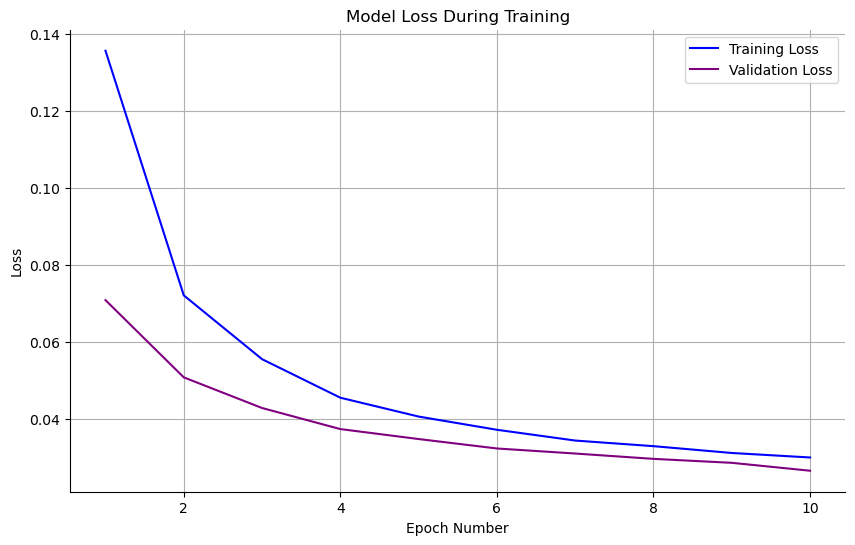

In [15]:
print("Started")

# Hyperparameters and dataset setup
num_layers = 3
lr = 0.001
hidden_dim = 56

# With progressive halving
model_56_nl3_prog, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim, num_layers, train_loader, test_loader, progressive_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.15233178033959122;  Validation Loss: 0.08328220780644262
Epoch 1: Train Loss: 0.08594976642634719;  Validation Loss: 0.06025135863515339
Epoch 2: Train Loss: 0.06488180607557296;  Validation Loss: 0.05091502850789729
Epoch 3: Train Loss: 0.05751898131566122;  Validation Loss: 0.04723140799525973
Epoch 4: Train Loss: 0.053861149807926265;  Validation Loss: 0.04560651052838229
Epoch 5: Train Loss: 0.050464436353649944;  Validation Loss: 0.04436981359173601
Epoch 6: Train Loss: 0.046758913586381824;  Validation Loss: 0.04073794818737506
Epoch 7: Train Loss: 0.04400791524676606;  Validation Loss: 0.03906433596584604
Epoch 8: Train Loss: 0.04111573736881837;  Validation Loss: 0.036525355155427694
Epoch 9: Train Loss: 0.038868635706603524;  Validation Loss: 0.03499231205858784


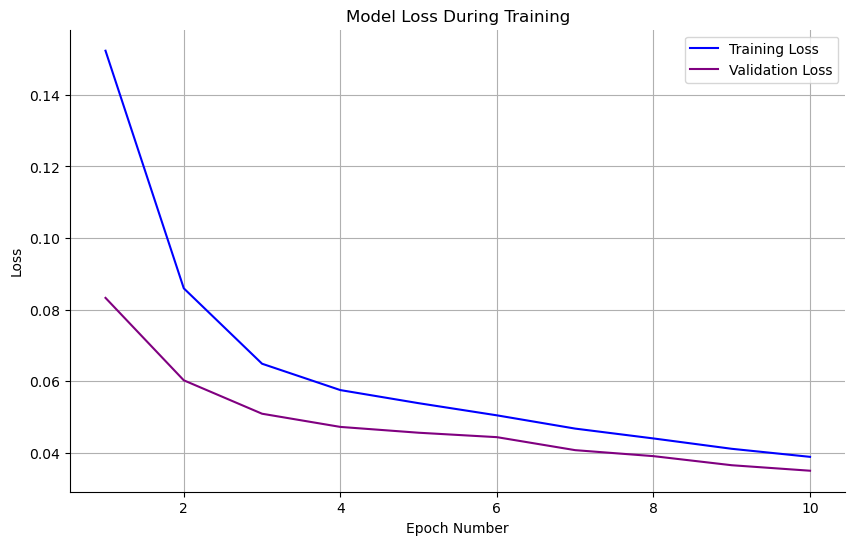

In [16]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001
hidden_dim_list = [56, 28, 14]

# With mirroring
model_56_28_14mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.2033619575202465;  Validation Loss: 0.12778097115295503
Epoch 1: Train Loss: 0.15236421744339168;  Validation Loss: 0.11642803087930328
Epoch 2: Train Loss: 0.13933708942495288;  Validation Loss: 0.11249907416462594
Epoch 3: Train Loss: 0.13236668352037667;  Validation Loss: 0.10859590223800315
Epoch 4: Train Loss: 0.12711392310447991;  Validation Loss: 0.10473869341824736
Epoch 5: Train Loss: 0.12275147014297545;  Validation Loss: 0.1014548589461198
Epoch 6: Train Loss: 0.11951975678093732;  Validation Loss: 0.10043491434058821
Epoch 7: Train Loss: 0.11724754921160638;  Validation Loss: 0.09767904332173723
Epoch 8: Train Loss: 0.11515288194641471;  Validation Loss: 0.09692920584526217
Epoch 9: Train Loss: 0.11350271268747747;  Validation Loss: 0.09553494099622631


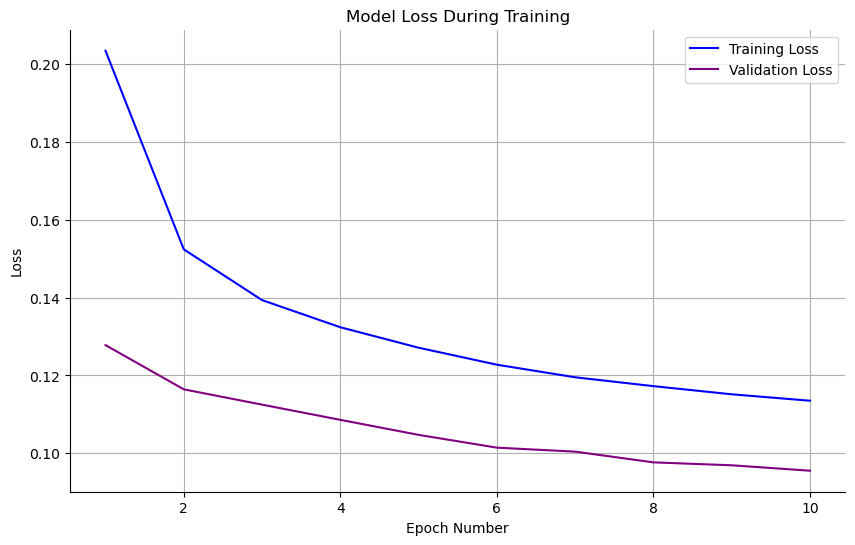

In [17]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [32, 16, 8, 3]
model_32_16_8_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.20412934562191368;  Validation Loss: 0.14518119423764245
Epoch 1: Train Loss: 0.16444404008798302;  Validation Loss: 0.11749117577933155
Epoch 2: Train Loss: 0.13865634761750698;  Validation Loss: 0.10932389996727282
Epoch 3: Train Loss: 0.1289806367829442;  Validation Loss: 0.10438107854534624
Epoch 4: Train Loss: 0.12297555413097143;  Validation Loss: 0.10231271433187838
Epoch 5: Train Loss: 0.11905559641309083;  Validation Loss: 0.09971389310833599
Epoch 6: Train Loss: 0.11532351213973016;  Validation Loss: 0.09631621776082154
Epoch 7: Train Loss: 0.10981645816937088;  Validation Loss: 0.09119374158183988
Epoch 8: Train Loss: 0.10454952968284488;  Validation Loss: 0.08719429633656174
Epoch 9: Train Loss: 0.10148032589349895;  Validation Loss: 0.08470256895311556


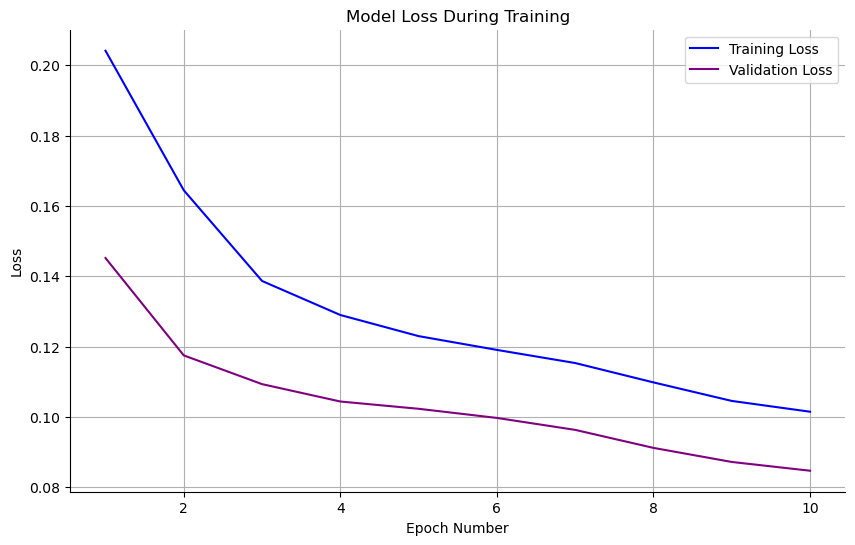

In [18]:
print("Started")

# Hyperparameters and dataset setup
num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [32, 16, 3]
model_32_16_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.18895906605757773;  Validation Loss: 0.14656144301216972
Epoch 1: Train Loss: 0.1673536635003984;  Validation Loss: 0.14299271538454508
Epoch 2: Train Loss: 0.15301593211479486;  Validation Loss: 0.1201490893156971
Epoch 3: Train Loss: 0.13458866742439568;  Validation Loss: 0.11132513526684548
Epoch 4: Train Loss: 0.1267429911531508;  Validation Loss: 0.10734508133835483
Epoch 5: Train Loss: 0.12017479240894317;  Validation Loss: 0.10128123371396214
Epoch 6: Train Loss: 0.11583373807370663;  Validation Loss: 0.09879243707436385
Epoch 7: Train Loss: 0.1128926396369934;  Validation Loss: 0.09656057943000781
Epoch 8: Train Loss: 0.11063467357307673;  Validation Loss: 0.09602807160010751
Epoch 9: Train Loss: 0.10948483732063323;  Validation Loss: 0.09370817763645355


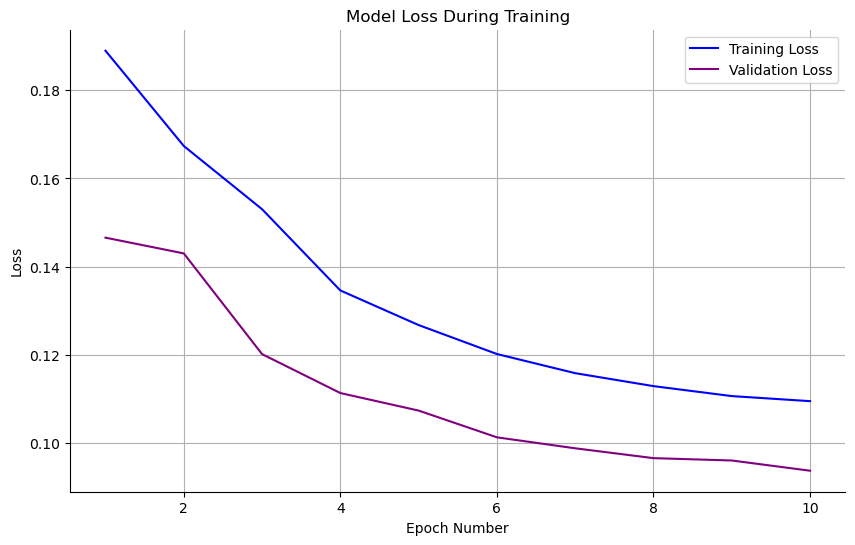

In [19]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [56, 28, 3]
model_56_28_3mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.1709688486531377;  Validation Loss: 0.09971589901798157
Epoch 1: Train Loss: 0.10489039374515415;  Validation Loss: 0.06985219617550052
Epoch 2: Train Loss: 0.07914332298096269;  Validation Loss: 0.05780903055161542
Epoch 3: Train Loss: 0.06689731779042632;  Validation Loss: 0.05247877794080319
Epoch 4: Train Loss: 0.061459292576182635;  Validation Loss: 0.04954619966542386
Epoch 5: Train Loss: 0.05832239432493225;  Validation Loss: 0.04769921465776861
Epoch 6: Train Loss: 0.05621277082245797;  Validation Loss: 0.04628666899195511
Epoch 7: Train Loss: 0.05436823768541217;  Validation Loss: 0.04547321188206575
Epoch 8: Train Loss: 0.052862612437456845;  Validation Loss: 0.044038709008956935
Epoch 9: Train Loss: 0.05083377708215266;  Validation Loss: 0.04273056795782581


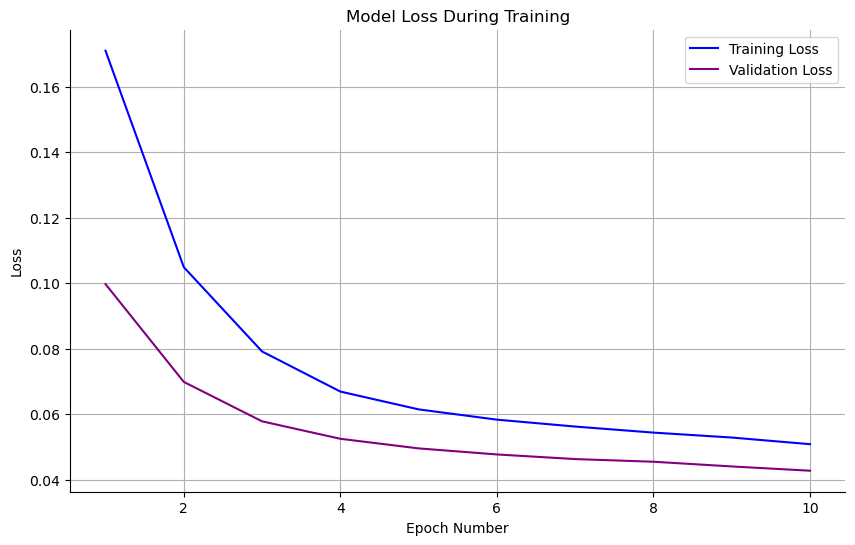

In [20]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [32, 24, 16]
model_32_24_16mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.20296442918479443;  Validation Loss: 0.14604405997254485
Epoch 1: Train Loss: 0.17073822421953083;  Validation Loss: 0.14353257516750648
Epoch 2: Train Loss: 0.16114377826452256;  Validation Loss: 0.13803318371920256
Epoch 3: Train Loss: 0.15383486985228956;  Validation Loss: 0.1333788472645897
Epoch 4: Train Loss: 0.14334080242551864;  Validation Loss: 0.12270001590023843
Epoch 5: Train Loss: 0.13568461891263722;  Validation Loss: 0.11778687664820832
Epoch 6: Train Loss: 0.1358123453333974;  Validation Loss: 0.11856725858524442
Epoch 7: Train Loss: 0.12593244723975658;  Validation Loss: 0.108866612797565
Epoch 8: Train Loss: 0.12109870850108564;  Validation Loss: 0.1052429622172245
Epoch 9: Train Loss: 0.11832263497635723;  Validation Loss: 0.10257474461817467


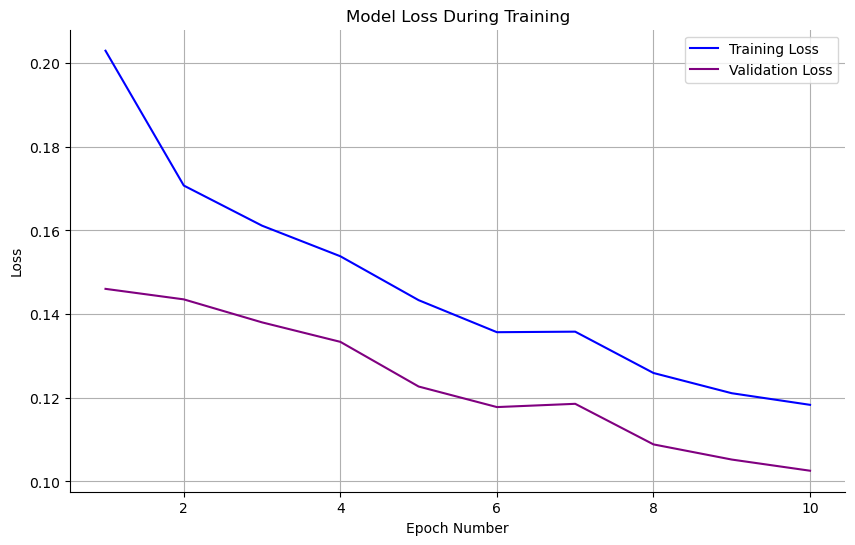

In [6]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [64, 42, 26, 16, 10, 7, 5, 3]
model_64_42_26_16_10_7_5_3, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.12738795862533153;  Validation Loss: 0.055640021750076235
Epoch 1: Train Loss: 0.05444583712378517;  Validation Loss: 0.03608947863317646
Epoch 2: Train Loss: 0.037671091873198746;  Validation Loss: 0.028760035643449092
Epoch 3: Train Loss: 0.030831419373862447;  Validation Loss: 0.02523202490363251
Epoch 4: Train Loss: 0.02606171840452589;  Validation Loss: 0.021342808062956686
Epoch 5: Train Loss: 0.022301049332600086;  Validation Loss: 0.018218862876113105
Epoch 6: Train Loss: 0.01973514739656821;  Validation Loss: 0.0164418120373145
Epoch 7: Train Loss: 0.017757620610063897;  Validation Loss: 0.014914737642821096
Epoch 8: Train Loss: 0.016223654366331174;  Validation Loss: 0.013849279209817
Epoch 9: Train Loss: 0.015140637301374226;  Validation Loss: 0.012865455203739527


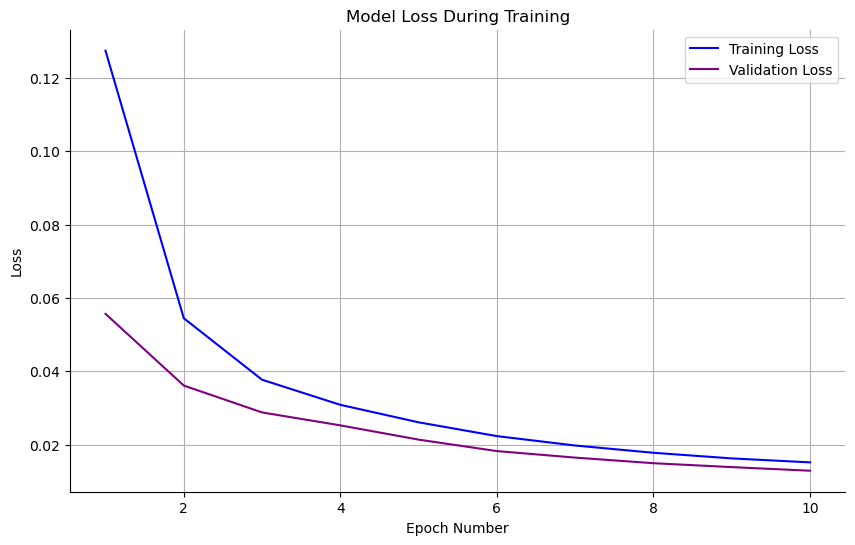

In [22]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [56, 28]
model_56_28mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.15386707333382219;  Validation Loss: 0.07354631053393099
Epoch 1: Train Loss: 0.07195088909938932;  Validation Loss: 0.04371564468542323
Epoch 2: Train Loss: 0.04746228766161949;  Validation Loss: 0.031517118473931655
Epoch 3: Train Loss: 0.03602625180501491;  Validation Loss: 0.025174696213442226
Epoch 4: Train Loss: 0.02931349949212745;  Validation Loss: 0.02128648340591581
Epoch 5: Train Loss: 0.024767592269927263;  Validation Loss: 0.01855207753797746
Epoch 6: Train Loss: 0.02160640455549583;  Validation Loss: 0.01647028894156541
Epoch 7: Train Loss: 0.01922722068266012;  Validation Loss: 0.014996171547028673
Epoch 8: Train Loss: 0.017396764474688096;  Validation Loss: 0.013536626081058413
Epoch 9: Train Loss: 0.015847164104343392;  Validation Loss: 0.012446161878665872


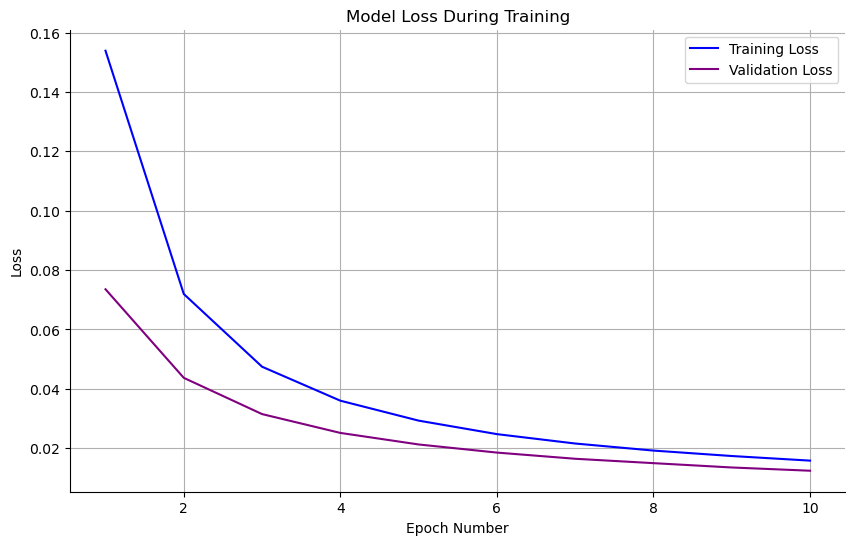

In [8]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [28]
model_28mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.12681427022907882;  Validation Loss: 0.05433685958447239
Epoch 1: Train Loss: 0.0519070083682891;  Validation Loss: 0.031242375595290785
Epoch 2: Train Loss: 0.033875911985524;  Validation Loss: 0.022748882717177347
Epoch 3: Train Loss: 0.0254573013051413;  Validation Loss: 0.018432168377627504
Epoch 4: Train Loss: 0.020531012443825603;  Validation Loss: 0.015461517372275512
Epoch 5: Train Loss: 0.017262309466605074;  Validation Loss: 0.013245949085400326
Epoch 6: Train Loss: 0.014909001157502644;  Validation Loss: 0.011862075886729516
Epoch 7: Train Loss: 0.013122184074018151;  Validation Loss: 0.010576674724336267
Epoch 8: Train Loss: 0.011713914893334731;  Validation Loss: 0.009674342927536024
Epoch 9: Train Loss: 0.010618720631464384;  Validation Loss: 0.008930764545488162


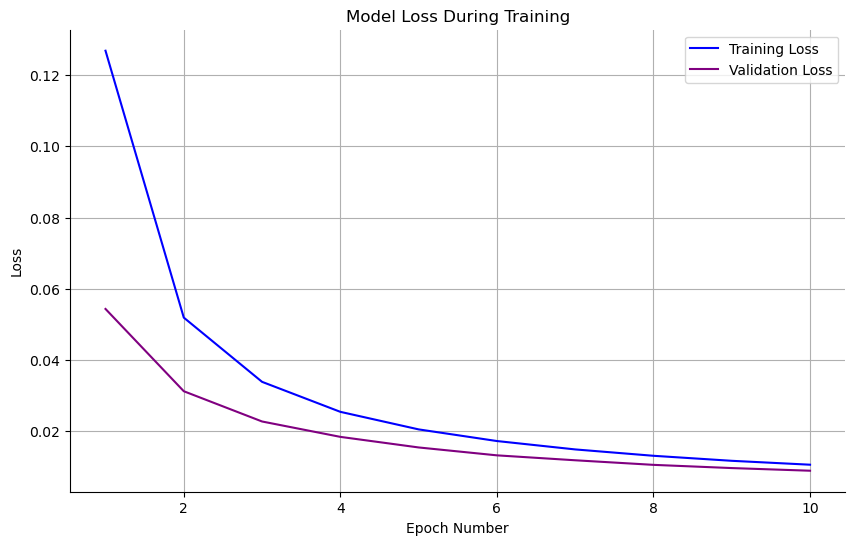

In [9]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [36]
model_, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.1730555145535618;  Validation Loss: 0.09110620639486504
Epoch 1: Train Loss: 0.09589808562304825;  Validation Loss: 0.05865575389922312
Epoch 2: Train Loss: 0.0659622001927346;  Validation Loss: 0.04413250744715808
Epoch 3: Train Loss: 0.05118262730538845;  Validation Loss: 0.035533604034512514
Epoch 4: Train Loss: 0.04243340742541477;  Validation Loss: 0.030812107755360668
Epoch 5: Train Loss: 0.036707642418332395;  Validation Loss: 0.027068236992428347
Epoch 6: Train Loss: 0.032241914316546175;  Validation Loss: 0.024381289844239623
Epoch 7: Train Loss: 0.02893699679407291;  Validation Loss: 0.022005419817643847
Epoch 8: Train Loss: 0.02646548945340328;  Validation Loss: 0.02033920634516553
Epoch 9: Train Loss: 0.024584305874304845;  Validation Loss: 0.019013626191810212


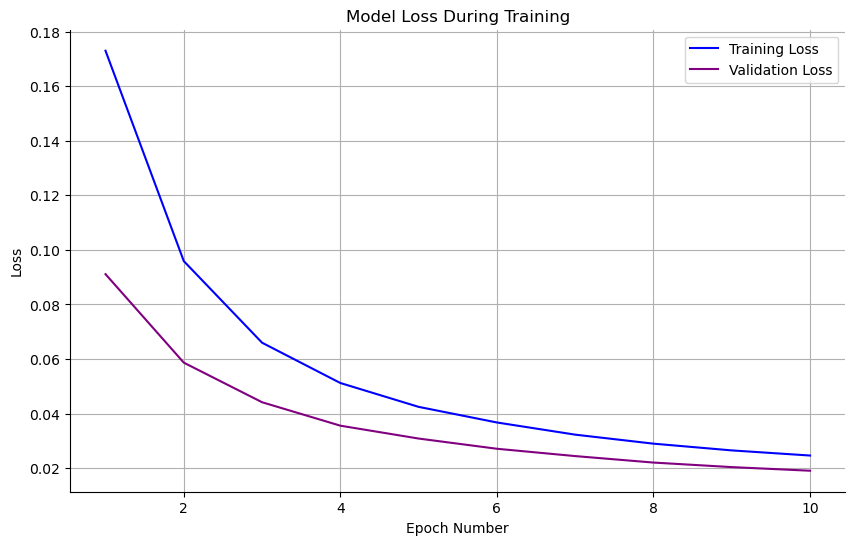

In [10]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20]
model_20mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.15019603131804615;  Validation Loss: 0.07735043942538679
Epoch 1: Train Loss: 0.07875005805399268;  Validation Loss: 0.05028955895947863
Epoch 2: Train Loss: 0.0556505028042011;  Validation Loss: 0.040219537921520714
Epoch 3: Train Loss: 0.04414651336846873;  Validation Loss: 0.0339589358149429
Epoch 4: Train Loss: 0.03722455722745508;  Validation Loss: 0.02941241265602448
Epoch 5: Train Loss: 0.03259901480050757;  Validation Loss: 0.026954395136420558
Epoch 6: Train Loss: 0.029994236532365902;  Validation Loss: 0.025079952080125863
Epoch 7: Train Loss: 0.027558939642040058;  Validation Loss: 0.02329990868183442
Epoch 8: Train Loss: 0.025248468160862104;  Validation Loss: 0.02114765144818063
Epoch 9: Train Loss: 0.023321694566402585;  Validation Loss: 0.019450511540433545


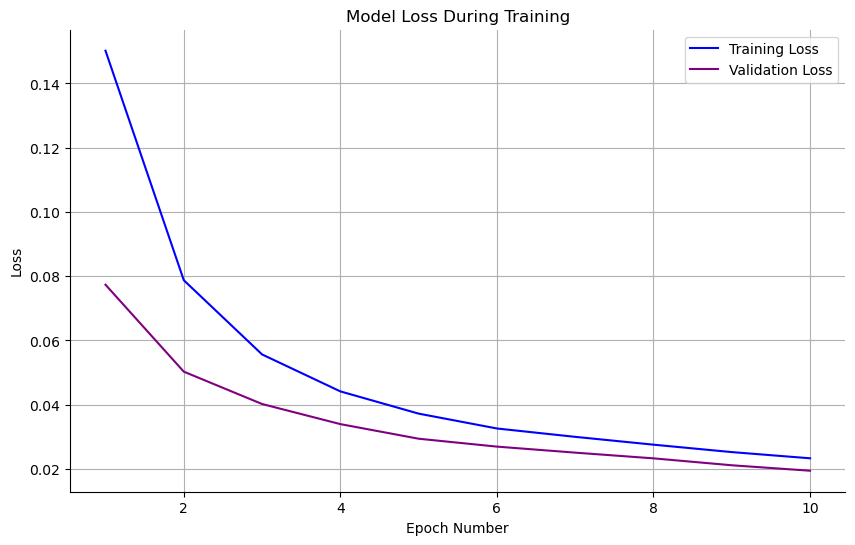

In [11]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [36, 20]
model_36_20mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.12073440407402813;  Validation Loss: 0.05125933828376405
Epoch 1: Train Loss: 0.04759008009568788;  Validation Loss: 0.027383892047955483
Epoch 2: Train Loss: 0.030460176937049256;  Validation Loss: 0.019996364679655574
Epoch 3: Train Loss: 0.022933902911609037;  Validation Loss: 0.015933148195843537
Epoch 4: Train Loss: 0.018375713448040187;  Validation Loss: 0.013287880629590921
Epoch 5: Train Loss: 0.01520781365397852;  Validation Loss: 0.011376222320570971
Epoch 6: Train Loss: 0.012900372094009072;  Validation Loss: 0.010002595207081367
Epoch 7: Train Loss: 0.011127820186084136;  Validation Loss: 0.00882435249157573
Epoch 8: Train Loss: 0.009737811383092775;  Validation Loss: 0.007691104685363825
Epoch 9: Train Loss: 0.008488517439400312;  Validation Loss: 0.006878732622848178


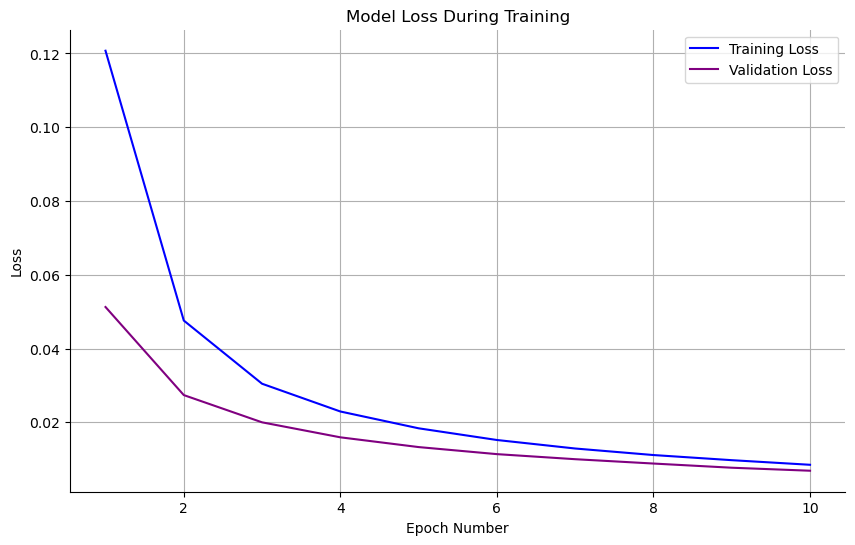

In [12]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [40]
model_40mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.1682503603864461;  Validation Loss: 0.09568514484004592
Epoch 1: Train Loss: 0.10704818465746939;  Validation Loss: 0.07759811236209484
Epoch 2: Train Loss: 0.08743615688290447;  Validation Loss: 0.06736232033260736
Epoch 3: Train Loss: 0.07934004452545196;  Validation Loss: 0.06302042137973998
Epoch 4: Train Loss: 0.07458925782702863;  Validation Loss: 0.05945742587625448
Epoch 5: Train Loss: 0.06660110664088278;  Validation Loss: 0.05152851690975379
Epoch 6: Train Loss: 0.059491464344318956;  Validation Loss: 0.048786433265135834
Epoch 7: Train Loss: 0.0568029347457923;  Validation Loss: 0.047542416022577305
Epoch 8: Train Loss: 0.055263578123413024;  Validation Loss: 0.04677896540640492
Epoch 9: Train Loss: 0.05425639773020521;  Validation Loss: 0.04597569260822267


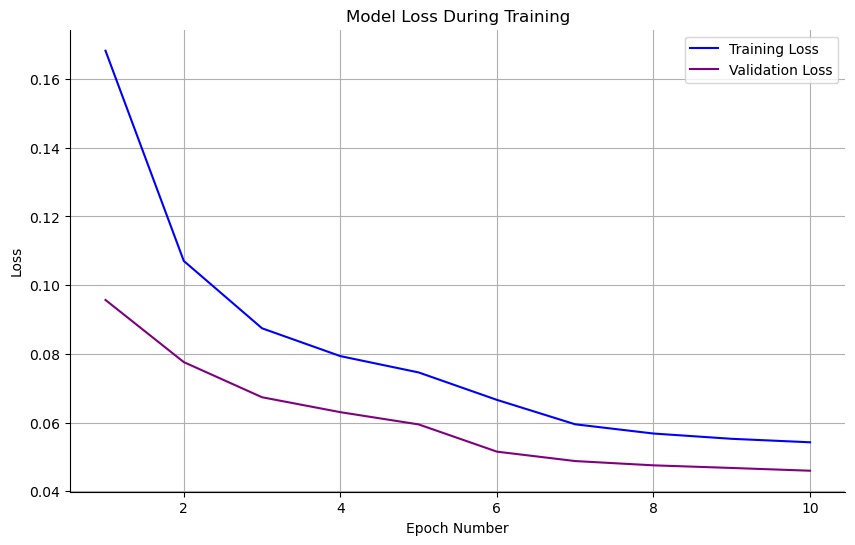

In [13]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [36, 20, 12]
model_36_20_12mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

Started
Epoch 0: Train Loss: 0.2001812679693103;  Validation Loss: 0.11718862470861867
Epoch 1: Train Loss: 0.12596503729000688;  Validation Loss: 0.08508858459821085
Epoch 2: Train Loss: 0.10111033725552261;  Validation Loss: 0.07059883219855172
Epoch 3: Train Loss: 0.08523066784255207;  Validation Loss: 0.06271401486877466
Epoch 4: Train Loss: 0.07723860263358802;  Validation Loss: 0.058404067759307066
Epoch 5: Train Loss: 0.06927097542211413;  Validation Loss: 0.05206404924772832
Epoch 6: Train Loss: 0.06093780637020245;  Validation Loss: 0.04748781514532237
Epoch 7: Train Loss: 0.05623619063990191;  Validation Loss: 0.0451821873050031
Epoch 8: Train Loss: 0.0532194202998653;  Validation Loss: 0.043456295979142724
Epoch 9: Train Loss: 0.05036708494881168;  Validation Loss: 0.04160757741014169


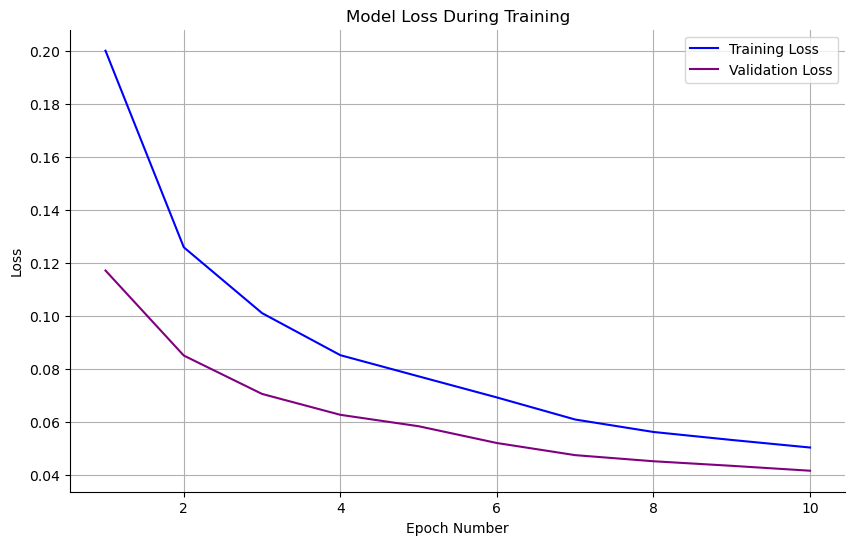

In [14]:
print("Started")

num_layers = None
lr = 0.001 # Not passed in rn
hidden_dim_list = [20, 12]
model_20_12mir, train_loss_log, test_loss_log = create_and_train_ae_model(input_dim, hidden_dim_list, num_layers, train_loader, test_loader, mirror_bool=True, ae_class_obj=RNNAutoencoder)

In [ ]:
assert(False)

Save a few of the above models

In [23]:
torch.save(model_56_28mir.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\RNNAE_56_28mir_vallossp013_BothPCA40.pth')
torch.save(model_32_16_3mir.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\RNNAE_32_16_3mir_vallossp084_BothPCA40.pth')

In [ ]:
assert(False)

## Old Grid Search
> Trying a ton of different architectures to find what's best for this dataset!
- Progressive should only be True, only False if nodes are being entered manually
- Not sure if this still works with the most recent version of the model code

In [ ]:
input_dim = 40  # Number of features
seq_len = 64  # Number of timesteps

# Define the parameter grid
param_grid = {
    'hidden_dim': [32, 64, 128],
    'num_layers': [2, 3, 4],
    'progressive': [True]  # Flag to halve the hidden units for each successive layer
}

# Run grid search
best_model, best_params = grid_search_rnn_autoencoder(train_loader, test_loader, input_dim, seq_len, param_grid)

- Trial: 0;: {'hidden_dim': 32, 'num_layers': 2, 'progressive': True}, Validation Loss: 0.02083
- 4- 
Trial: 1s: {'hidden_dim': 32, 'num_layers': 2, 'progressive': False}, Validation Loss: 0.016
- 3- 35
Trial:ams: {'hidden_dim': 32, 'num_layers': 3, 'progressive': True}, Validation Loss: 0.0
- 7- 5635
Triaarams: {'hidden_dim': 32, 'num_layers': 3, 'progressive': False}, Validation Loss: 0
- 5- 940434
Tr
Params: {'hidden_dim': 32, 'num_layers': 4, 'progressive': True}, Validation Loss:
- 7- 31617157 e
Params: {'hidden_dim': 32, 'num_layers': 4, 'progressive': False}, Validation Los
- 0- 6267585271rue
Params: {'hidden_dim': 64, 'num_layers': 2, 'progressive': True}, Validation Lo
- 8- 4156883282False
Params: {'hidden_dim': 64, 'num_layers': 2, 'progressive': False}, Validation 
- 5- 4547723424e: True
Params: {'hidden_dim': 64, 'num_layers': 3, 'progressive': True}, Validati
- 2- 2054176014ve: False
Params: {'hidden_dim': 64, 'num_layers': 3, 'progressive': False}, Valida
- .- 01182716042ssive: True
Params: {'hidden_dim': 64, 'num_layers': 4, 'progressive': True}, Vali
- :-  0.04446715essive: False
Params: {'hidden_dim': 64, 'num_layers': 4, 'progressive': False}, Va
- s- : 0.0171945ogressive: True
Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': True}, 
- s- s: 0.002466rogressive: False
Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': False}
- L- oss: 0.0017; progressive: True
Params: {'hidden_dim': 128, 'num_layers': 3, 'progressive': Tru
- o- n Loss: 0.03; progressive: False
Params: {'hidden_dim': 128, 'num_layers': 3, 'progressive': Fa
- t- ion Loss: 0s: 4; progressive: True
Params: {'hidden_dim': 128, 'num_layers': 4, 'progressive'5
- d- ation Loss:rs: 4; progressive: False
Params: {'hidden_dim': 128, 'num_layers': 4, 'progressive
- l- idation Loss: 0.010927938756399922
Best Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': Fallidation Loss: 0.0017131721086079037


__Best model from above:__ <br>
Trial: 13; hidden_dim: 128; num_layers: 2; progressive: False <br>
Params: {'hidden_dim': 128, 'num_layers': 2, 'progressive': False}, Validation Loss: 0.0017131721086079037

In [ ]:
torch.save(best_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\RNNAE_latent128_progFalse_numlayers2_trial13_vallossp001_BothPCA40.pth')

In [ ]:
assert(False)

# Temporal Convolution Autoencoder

In [ ]:
# This one is different but not sure what the effect is...
## Observed a higher starting loss, only sort of converged, loss only somewhat decreased
#class TCNEncoder(nn.Module):
#    def __init__(self, input_dim, hidden_dim, kernel_size):
#        super(TCNEncoder, self).__init__()
#        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size//2, stride=2)  # Adjusted stride
#        
#    def forward(self, x):
#        x = x.permute(0, 2, 1)
#        x = torch.relu(self.conv1(x))
#        return x

class TCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(TCNEncoder, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=kernel_size//2)
        self.pool = nn.MaxPool1d(2)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        return x

class TCNDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, kernel_size):
        super(TCNDecoder, self).__init__()
        self.conv1 = nn.ConvTranspose1d(hidden_dim, hidden_dim, kernel_size, stride=2, padding=kernel_size//2, output_padding=1)  # Adjusted to maintain dimensions
        self.conv2 = nn.Conv1d(hidden_dim, output_dim, kernel_size=1)  # Convolution to adjust channels if needed

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))  # Apply activation after the final convolution
        x = x.permute(0, 2, 1)  # Permute dimensions to match the desired output size
        return x

class TCNAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(TCNAutoencoder, self).__init__()
        self.encoder = TCNEncoder(input_dim, hidden_dim, kernel_size)
        self.decoder = TCNDecoder(hidden_dim, input_dim, kernel_size)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        

In [ ]:
# Hyperparameters
input_dim = 40
hidden_dim = 64
kernel_size = 5
num_epochs = 10
learning_rate = 0.001

# Model, Loss, and Optimizer
temp_conv_ae_model = TCNAutoencoder(input_dim, hidden_dim, kernel_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(temp_conv_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = temp_conv_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

# Varitational Autoencoder

## PP

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Encoder Network
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

    def forward(self, x):
        _, hidden = self.rnn(x)
        hidden = hidden.squeeze(0)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc_hidden = nn.Linear(latent_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        hidden = self.fc_hidden(z).unsqueeze(0)
        output, _ = self.rnn(hidden)
        output = self.fc_output(output)
        return output

# Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, output_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001
latent_size = 16
hidden_size = 64

# Create data loader
#train_loader = torch.utils.data.DataLoader(dummy_data, batch_size=batch_size, shuffle=True)

# Loss function
reconstruction_loss = nn.MSELoss(reduction='sum')

In [8]:
# Initialize VAE model
input_size = 40
output_size = 40
vae = VAE(input_size, hidden_size, latent_size, output_size)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)


In [11]:
# Training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        #print(type(batch))
        #print(batch.shape)
        #batch = batch.view(-1, 64, 40)  # Reshape batch for RNN input
        optimizer.zero_grad()

        # Forward pass
        x_recon, mu, logvar = vae(batch)
        print(type(x_recon))
        print(x_recon.shape)
        # Reconstruction loss
        recon_loss = reconstruction_loss(x_recon, batch)
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Total loss
        loss = recon_loss + kl_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader.dataset):.4f}")

# Save the trained model
#torch.save(vae.state_dict(), 'vae_model.pth')

<class 'torch.Tensor'>
torch.Size([1, 32, 40])


RuntimeError: The size of tensor a (32) must match the size of tensor b (64) at non-singleton dimension 1

## Jackson Kang

In [31]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat


class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)#.to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [33]:
# Hyperparameters
batch_size = 32
epochs = 10
lr = 0.001

latent_dim = 16
hidden_dim = 64
x_dim = 40


In [34]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = VAE(Encoder=encoder, Decoder=decoder)#.to(DEVICE)

In [35]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [36]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    #for batch_idx, (x, _) in enumerate(train_loader):
    for batch_idx, (x) in enumerate(train_loader):
        #x = x.view(batch_size, x_dim)
        x = x.view(batch_size, hidden_dim, x_dim)
        #x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...


RuntimeError: shape '[32, 64, 40]' is invalid for input of size 61440

## CG

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, use_xavier_init=True):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim*2)  # mean and logvar
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        # Initialize weights using Xavier initialization
        if use_xavier_init:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    torch.nn.init.xavier_uniform_(m.weight)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_dim), reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD


In [ ]:
print("Starting")

# Hyperparameters
#input_dim = data.size(1) * data.size(2)
input_dim = 64 * 40
hidden_dim = 128
latent_dim = 32
num_epochs = 50
learning_rate = 0.001

# Model, Loss, and Optimizer
vae_model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(batch)
        loss = vae_model.loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
torch.save(vae_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\BrokenVAE_hidden128_latent32_NegativeLossesLol.pth')

# Sparse Autoencoder

In [ ]:
# ONE LAYER SparseAE

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.sigmoid(self.decoder(encoded))
        return decoded

In [ ]:
input_dim = 40
hidden_dim = 12
num_epochs = 20
learning_rate = 0.001

# Model, Loss, and Optimizer
sparse_ae_model = SparseAutoencoder(input_dim, hidden_dim)
optimizer = optim.Adam(sparse_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = sparse_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
torch.save(sparse_ae_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\SparseAE_latent12_onelayer_conv_trainlossp08.pth')

In [ ]:
# N LAYER SparseAE
## NOT WORKING YET

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(SparseAutoencoder, self).__init__()
        if type(hidden_dims) is int:
            hidden_dims = list(hidden_dims)
        
        # Encoder layers
        encoder_layers = []
        for i in range(len(hidden_dims) - 1):
            encoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder layers
        decoder_layers = []
        for i in range(len(hidden_dims) - 1, 0, -1):
            decoder_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i-1]))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(hidden_dims[0], input_dim))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)
        self.output_layer = nn.Linear(hidden_dims[-1], input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        output = self.output_layer(decoded)
        return decoded

In [ ]:
input_dim = 40
hidden_dim_lst = [3]
num_epochs = 20
learning_rate = 0.001

# Model, Loss, and Optimizer
sparse_ae_model = SparseAutoencoder(input_dim, hidden_dim_lst)
optimizer = optim.Adam(sparse_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = sparse_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Denoising Autoencoder

In [ ]:
# ONE LAYER DenoisingAE

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.sigmoid(self.decoder(encoded))
        return decoded

    def add_noise(self, x, noise_level=0.1):
        # Add Gaussian noise to the input
        noise = torch.randn_like(x) * noise_level
        return x + noise

In [ ]:
input_dim = 40
hidden_dim = 12
num_epochs = 20
learning_rate = 0.001

# Model, Loss, and Optimizer
denoising_ae_model = DenoisingAutoencoder(input_dim, hidden_dim)
optimizer = optim.Adam(denoising_ae_model.parameters(), lr=learning_rate)

# Training
for epoch in range(num_epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        output = denoising_ae_model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
torch.save(denoising_ae_model.state_dict(), 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\denoisingAE_flatconv_onelayer_latent12.pth')